### 这部分是生成submission的代码,也就是在测试数据上的inference.

Please check out Guido's excellent kernel [here](https://www.kaggle.com/gzuidhof/reference-model). In this kernel i show how to perform inference on test set using the trained model.

You can find the BEV of the test set [here](https://www.kaggle.com/meaninglesslives/lyft3d-test-dataset). 

## Updates:
- Corrected yaw calculation
- Used category height information 


# Install the Lyft SDK

In [33]:
from datetime import datetime
from functools import partial
import glob
from multiprocessing import Pool

# Disable multiprocesing for numpy/opencv. We already multiprocess ourselves, this would mean every subprocess produces
# even more threads which would lead to a lot of context switching, slowing things down a lot.
import os
os.environ["OMP_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import cv2
from PIL import Image
import numpy as np
from tqdm import tqdm, tqdm_notebook
import scipy
import scipy.ndimage
import scipy.special
from scipy.spatial.transform import Rotation as R

from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud, Box, Quaternion
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix

import time
from lyft_dataset_sdk.utils.map_mask import MapMask
from pathlib import Path
from lyft_dataset_sdk.lyftdataset import LyftDataset,LyftDatasetExplorer

# Lyft SDK requires creating a link to input folders

In [34]:
!ln -s /home/bob/data/lyft_data/test_images images
!ln -s /home/bob/data/lyft_data/test_maps maps
!ln -s /home/bob/data/lyft_data/test_lidar lidar

ln: failed to create symbolic link 'images/test_images': File exists
ln: failed to create symbolic link 'maps/test_maps': File exists
ln: failed to create symbolic link 'lidar/test_lidar': File exists


# Creating a new test class
### If you try to use original LyftDataset Class, you will get missing table error

In [35]:
class LyftTestDataset(LyftDataset):
    """Database class for Lyft Dataset to help query and retrieve information from the database."""

    def __init__(self, data_path: str, json_path: str, verbose: bool = True, map_resolution: float = 0.1):
        """Loads database and creates reverse indexes and shortcuts.
        Args:
            data_path: Path to the tables and data.
            json_path: Path to the folder with json files
            verbose: Whether to print status messages during load.
            map_resolution: Resolution of maps (meters).
        """

        self.data_path = Path(data_path).expanduser().absolute()
        self.json_path = Path(json_path)

        self.table_names = [
            "category",
            "attribute",
            "sensor",
            "calibrated_sensor",
            "ego_pose",
            "log",
            "scene",
            "sample",
            "sample_data",
            "map",
        ]

        start_time = time.time()

        # Explicitly assign tables to help the IDE determine valid class members.
        self.category = self.__load_table__("category")
        self.attribute = self.__load_table__("attribute")
        
        
        self.sensor = self.__load_table__("sensor")
        self.calibrated_sensor = self.__load_table__("calibrated_sensor")
        self.ego_pose = self.__load_table__("ego_pose")
        self.log = self.__load_table__("log")
        self.scene = self.__load_table__("scene")
        self.sample = self.__load_table__("sample")
        self.sample_data = self.__load_table__("sample_data")
        
        self.map = self.__load_table__("map")

        if verbose:
            for table in self.table_names:
                print("{} {},".format(len(getattr(self, table)), table))
            print("Done loading in {:.1f} seconds.\n======".format(time.time() - start_time))

        # Initialize LyftDatasetExplorer class
        self.explorer = LyftDatasetExplorer(self)
        # Make reverse indexes for common lookups.
        self.__make_reverse_index__(verbose)
        
    def __make_reverse_index__(self, verbose: bool) -> None:
        """De-normalizes database to create reverse indices for common cases.
        Args:
            verbose: Whether to print outputs.
        """

        start_time = time.time()
        if verbose:
            print("Reverse indexing ...")

        # Store the mapping from token to table index for each table.
        self._token2ind = dict()
        for table in self.table_names:
            self._token2ind[table] = dict()

            for ind, member in enumerate(getattr(self, table)):
                self._token2ind[table][member["token"]] = ind

        # Decorate (adds short-cut) sample_data with sensor information.
        for record in self.sample_data:
            cs_record = self.get("calibrated_sensor", record["calibrated_sensor_token"])
            sensor_record = self.get("sensor", cs_record["sensor_token"])
            record["sensor_modality"] = sensor_record["modality"]
            record["channel"] = sensor_record["channel"]

        # Reverse-index samples with sample_data and annotations.
        for record in self.sample:
            record["data"] = {}
            record["anns"] = []

        for record in self.sample_data:
            if record["is_key_frame"]:
                sample_record = self.get("sample", record["sample_token"])
                sample_record["data"][record["channel"]] = record["token"]

        if verbose:
            print("Done reverse indexing in {:.1f} seconds.\n======".format(time.time() - start_time))

In [36]:
classes = ["car", "motorcycle", "bus", "bicycle", "truck", 
           "pedestrian", "other_vehicle", "animal", "emergency_vehicle"]

# Find the mean height of all categories
We can use the mean height instead of blindly using 1.75m for all categories

In [37]:
class_heights = {'animal':0.51,'bicycle':1.44,'bus':3.44,'car':1.72,'emergency_vehicle':2.39,'motorcycle':1.59,
                'other_vehicle':3.23,'pedestrian':1.78,'truck':3.44}
level5data = LyftTestDataset(data_path='.', json_path='/home/bob/data/lyft_data/test_data', verbose=True)

9 category,
17 attribute,
8 sensor,
168 calibrated_sensor,
219744 ego_pose,
218 log,
218 scene,
27468 sample,
219744 sample_data,
1 map,
Done loading in 2.5 seconds.
Reverse indexing ...
Done reverse indexing in 0.8 seconds.


In [38]:
def move_boxes_to_car_space(boxes, ego_pose):
    """
    Move boxes from world space to car space.
    Note: mutates input boxes.
    """
    translation = -np.array(ego_pose['translation'])
    rotation = Quaternion(ego_pose['rotation']).inverse
    
    for box in boxes:
        # Bring box to car space
        box.translate(translation)
        box.rotate(rotation)
        
def scale_boxes(boxes, factor):
    """
    Note: mutates input boxes
    """
    for box in boxes:
        box.wlh = box.wlh * factor

def draw_boxes(im, voxel_size, boxes, classes, z_offset=0.0):
    for box in boxes:
        # We only care about the bottom corners
        corners = box.bottom_corners()
        corners_voxel = car_to_voxel_coords(corners, im.shape, voxel_size, z_offset).transpose(1,0)
        corners_voxel = corners_voxel[:,:2] # Drop z coord

        class_color = classes.index(box.name) + 1
        
        if class_color == 0:
            raise Exception("Unknown class: {}".format(box.name))

        cv2.drawContours(im, np.int0([corners_voxel]), 0, (class_color, class_color, class_color), -1)

In [39]:
# Some hyperparameters we'll need to define for the system
voxel_size = (0.3, 0.3, 1.0)
z_offset = -2.0
bev_shape = (496, 496, 3)

# We scale down each box so they are more separated when projected into our coarse voxel space.
box_scale = 0.9

In [40]:
def visualize_lidar_of_sample(sample_token, axes_limit=80):
    sample = level5data.get("sample", sample_token)
    sample_lidar_token = sample["data"]["LIDAR_TOP"]
    level5data.render_sample_data(sample_lidar_token, axes_limit=axes_limit)

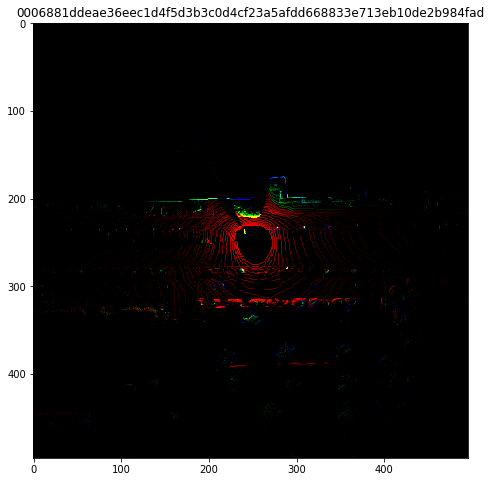

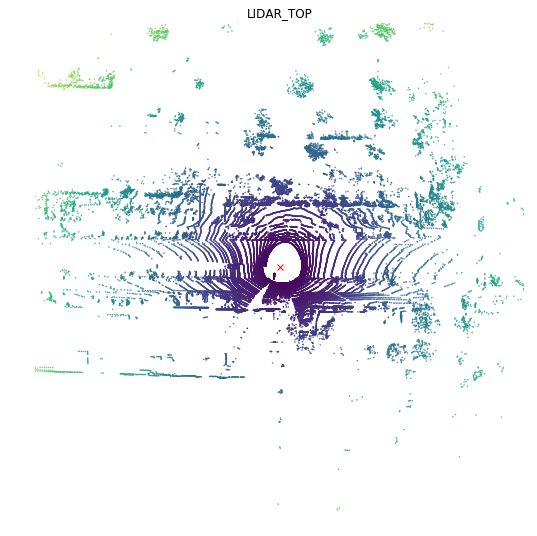

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torchvision.models import resnet

class BEVImageDataset(torch.utils.data.Dataset):
    def __init__(self, input_filepaths, map_filepaths=None):
        self.input_filepaths = input_filepaths
        self.map_filepaths = map_filepaths
        if map_filepaths is not None:
            assert len(input_filepaths) == len(map_filepaths)
            
    def __len__(self):
        return len(self.input_filepaths)

    def __getitem__(self, idx):
        input_filepath = self.input_filepaths[idx]
        sample_token = input_filepath.split("/")[-1].replace("_input.png","")
        im = cv2.imread(input_filepath, cv2.IMREAD_UNCHANGED)        
        if self.map_filepaths:
            map_filepath = self.map_filepaths[idx]
            map_im = cv2.imread(map_filepath, cv2.IMREAD_UNCHANGED)
            im = np.concatenate((im, map_im), axis=2)
        im = im.astype(np.float32)/255
        im = torch.from_numpy(im.transpose(2,0,1))
        return im, sample_token

    
test_data_folder = './artifacts/'
input_filepaths = sorted(glob.glob(os.path.join(test_data_folder, "*_input.png")))
#map_filepaths = sorted(glob.glob(os.path.join(test_data_folder, "*_map.png")))
test_dataset = BEVImageDataset(input_filepaths)
    
im, sample_token = test_dataset[1]
im = im.numpy()

plt.figure(figsize=(16,8))

# Transpose the input volume CXY to XYC order, which is what matplotlib requires.
# plt.imshow(np.hstack((im.transpose(1,2,0)[...,:3], target_as_rgb)))
plt.imshow(im.transpose(1,2,0)[...,:3])
plt.title(sample_token)
plt.show()

visualize_lidar_of_sample(sample_token)

# Unet Model

In [43]:
# This implementation was copied from https://github.com/jvanvugt/pytorch-unet, it is MIT licensed.

class UNet(nn.Module):
    def __init__(
        self,
        in_channels=1,
        n_classes=2,
        depth=5,
        wf=6,
        padding=False,
        batch_norm=False,
        up_mode='upconv',
    ):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(
                UNetConvBlock(prev_channels, 2 ** (wf + i), padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(
                UNetUpBlock(prev_channels, 2 ** (wf + i), up_mode, padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])
        ]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

We train a U-net fully convolutional neural network, we create a network that is less deep and with only half the amount of filters compared to the original U-net paper implementation. We do this to keep training and inference time low.

# Res-Unet

In [44]:
## ResUnet Model
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.weight.data.normal_(0, 1e-3)
        if m.bias is not None:
            m.bias.data.zero_()
    elif isinstance(m, nn.ConvTranspose2d):
        m.weight.data.normal_(0, 1e-3)
        if m.bias is not None:
            m.bias.data.zero_()
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()

def conv_bn_relu(in_channels, out_channels, kernel_size, \
        stride=1, padding=0, bn=True, relu=True):
    bias = not bn
    layers = []
    layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride,
        padding, bias=bias))
    if bn:
        layers.append(nn.BatchNorm2d(out_channels))
    if relu:
        layers.append(nn.LeakyReLU(0.2, inplace=True))
    layers = nn.Sequential(*layers)

    # initialize the weights
    for m in layers.modules():
        init_weights(m)

    return layers

def convt_bn_relu(in_channels, out_channels, kernel_size, \
        stride=1, padding=0, output_padding=0, bn=True, relu=True):
    bias = not bn
    layers = []
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size,
        stride, padding, output_padding, bias=bias))
    if bn:
        layers.append(nn.BatchNorm2d(out_channels))
    if relu:
        layers.append(nn.LeakyReLU(0.2, inplace=True))
    layers = nn.Sequential(*layers)

    # initialize the weights
    for m in layers.modules():
        init_weights(m)

    return layers

class DepthCompletionNet(nn.Module):
    def __init__(self, num_out_channels, res_layers=34, pretrained=False):
        assert (res_layers in [18, 34, 50, 101, 152]
               ),'Only layers 18, 34, 50, 101, and 152 are defined, but got {}'.format(res_layers)
        super(DepthCompletionNet, self).__init__()
        channels = 64
        self.conv1_img = conv_bn_relu(3, channels, kernel_size=3, stride=1, padding=1)
        pretrained_model = resnet.__dict__['resnet{}'.format(res_layers)](pretrained=pretrained)
        if not pretrained:
            pretrained_model.apply(init_weights)
        #self.maxpool = pretrained_model._modules['maxpool']
        self.conv2 = pretrained_model._modules['layer1']
        self.conv3 = pretrained_model._modules['layer2']
        self.conv4 = pretrained_model._modules['layer3']
        self.conv5 = pretrained_model._modules['layer4']
        del pretrained_model # clear memory

        # define number of intermediate channels
        if res_layers <= 34:
            num_channels = 512
        elif res_layers >= 50:
            num_channels = 2048
        self.conv6 = conv_bn_relu(num_channels, 512, kernel_size=3, stride=2, padding=1)

        # decoding layers
        kernel_size = 3
        stride = 2
        self.convt5 = convt_bn_relu(in_channels=512, out_channels=256,
            kernel_size=kernel_size, stride=stride, padding=1, output_padding=1)
        self.convt4 = convt_bn_relu(in_channels=768, out_channels=128,
            kernel_size=kernel_size, stride=stride, padding=1, output_padding=1)
        self.convt3 = convt_bn_relu(in_channels=(256+128), out_channels=64,
            kernel_size=kernel_size, stride=stride, padding=1, output_padding=1)
        self.convt2 = convt_bn_relu(in_channels=(128+64), out_channels=64,
            kernel_size=kernel_size, stride=stride, padding=1, output_padding=1)
        self.convt1 = convt_bn_relu(in_channels=128, out_channels=64,
            kernel_size=kernel_size, stride=1, padding=1)
        self.convtf = conv_bn_relu(in_channels=128, out_channels=num_out_channels, kernel_size=1, 
                                   stride=1, bn=False, relu=False)

    def forward(self, x):
        # first layer
        conv1 = self.conv1_img(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2) # batchsize * ? * 176 * 608
        conv4 = self.conv4(conv3) # batchsize * ? * 88 * 304
        conv5 = self.conv5(conv4) # batchsize * ? * 44 * 152
        conv6 = self.conv6(conv5) # batchsize * ? * 22 * 76

        # decoder
        convt5 = self.convt5(conv6)
        y = torch.cat((convt5, conv5), 1)
        convt4 = self.convt4(y)
        y = torch.cat((convt4, conv4), 1)
        convt3 = self.convt3(y)
        y = torch.cat((convt3, conv3), 1)
        convt2 = self.convt2(y)
        y = torch.cat((convt2, conv2), 1)
        convt1 = self.convt1(y)
        y = torch.cat((convt1,conv1), 1)
        y = self.convtf(y)

        if self.training:
            return 100 * y
        else:
            min_distance = 0.9
            return F.relu(100 * y - min_distance) + min_distance 
        # the minimum range of Velodyne is around 3 feet ~= 0.9m

In [45]:
def get_unet_model(in_channels=3, num_output_classes=2):
    model = UNet(in_channels=in_channels, n_classes=num_output_classes, wf=6, depth=5, padding=True, up_mode='upsample')
    
    # Optional, for multi GPU training and inference
    return model


In [46]:
def visualize_predictions(input_image, prediction, n_images=2, apply_softmax=True):
    """
    Takes as input 3 PyTorch tensors, plots the input image, predictions and targets.
    """
    # Only select the first n images
    prediction = prediction[:n_images]

    input_image = input_image[:n_images]

    prediction = prediction.detach().cpu().numpy()
    if apply_softmax:
        prediction = scipy.special.softmax(prediction, axis=1)
    class_one_preds = np.hstack(1-prediction[:,0])


    class_rgb = np.repeat(class_one_preds[..., None], 3, axis=2)
    class_rgb[...,2] = 0

    
    input_im = np.hstack(input_image.cpu().numpy().transpose(0,2,3,1))
    
    if input_im.shape[2] == 3:
        input_im_grayscale = np.repeat(input_im.mean(axis=2)[..., None], 3, axis=2)
        overlayed_im = (input_im_grayscale*0.6 + class_rgb*0.7).clip(0,1)
    else:
        input_map = input_im[...,3:]
        overlayed_im = (input_map*0.6 + class_rgb*0.7).clip(0,1)

    thresholded_pred = np.repeat(class_one_preds[..., None] > 0.5, 3, axis=2)

    fig = plt.figure(figsize=(12,26))
    plot_im = np.vstack([class_rgb, input_im[...,:3], overlayed_im, thresholded_pred]).clip(0,1).astype(np.float32)
    plt.imshow(plot_im)
    plt.axis("off")
    plt.show()

In [47]:
# We weigh the loss for the 0 class lower to account for (some of) the big class imbalance.
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weights = torch.from_numpy(np.array([0.2] + [1.0]*len(classes), dtype=np.float32))
class_weights = class_weights.to(device)

# Loading Pretrained model

In [48]:
# del model
batch_size = 8
epochs = 15 # Note: We may be able to train for longer and expect better results, the reason this number is low is to keep the runtime short.

model = get_unet_model(in_channels=3, num_output_classes=len(classes)+1)
#model = DepthCompletionNet(num_out_channels=len(classes)+1, res_layers=34)
state = torch.load('../artifacts/unet_500/unet_epoch_13.pth')
model.load_state_dict(state)
model = model.to(device)
model.eval()


UNet(
  (down_path): ModuleList(
    (0): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (1): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (2): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (3): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(

In [49]:
def calc_detection_box(prediction_opened,class_probability):

    sample_boxes = []
    sample_detection_scores = []
    sample_detection_classes = []
    
    contours, hierarchy = cv2.findContours(prediction_opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
    
    for cnt in contours:
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        
        # Let's take the center pixel value as the confidence value
        box_center_index = np.int0(np.mean(box, axis=0))
        
        for class_index in range(len(classes)):
            box_center_value = class_probability[class_index+1, box_center_index[1], box_center_index[0]]
            
            # Let's remove candidates with very low probability
            if box_center_value < 0.01:
                continue
            
            box_center_class = classes[class_index]

            box_detection_score = box_center_value
            sample_detection_classes.append(box_center_class)
            sample_detection_scores.append(box_detection_score)
            sample_boxes.append(box)
            
    return np.array(sample_boxes),sample_detection_scores,sample_detection_classes

In [50]:
# We perform an opening morphological operation to filter tiny detections
# Note that this may be problematic for classes that are inherently small (e.g. pedestrians)..
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    
def open_preds(predictions_non_class0):

    predictions_opened = np.zeros((predictions_non_class0.shape), dtype=np.uint8)

    for i, p in enumerate(tqdm(predictions_non_class0)):
        thresholded_p = (p > background_threshold).astype(np.uint8)
        predictions_opened[i] = cv2.morphologyEx(thresholded_p, cv2.MORPH_OPEN, kernel)
        
    return predictions_opened

# Test Set Predictions

In [51]:
import gc
gc.collect()
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=True, num_workers=os.cpu_count()*2)
progress_bar = tqdm_notebook(test_loader)

sample_tokens = []
all_losses = []

detection_boxes = []
detection_scores = []
detection_classes = []

# Arbitrary threshold in our system to create a binary image to fit boxes around.
background_threshold = 200

with torch.no_grad():
    model.eval()
    for ii, (X, batch_sample_tokens) in enumerate(progress_bar):

        sample_tokens.extend(batch_sample_tokens)
        
        X = X.to(device)  # [N, 1, H, W]
        prediction = model(X)  # [N, 2, H, W]
        
        prediction = F.softmax(prediction, dim=1)
        
        prediction_cpu = prediction.cpu().numpy()
        predictions = np.round(prediction_cpu*255).astype(np.uint8)
        
        # Get probabilities for non-background
        predictions_non_class0 = 255 - predictions[:,0]
        
        predictions_opened = np.zeros((predictions_non_class0.shape), dtype=np.uint8)

        for i, p in enumerate(predictions_non_class0):
            thresholded_p = (p > background_threshold).astype(np.uint8)
            predictions_opened[i] = cv2.morphologyEx(thresholded_p, cv2.MORPH_OPEN, kernel)
    
            sample_boxes,sample_detection_scores,sample_detection_classes = calc_detection_box(predictions_opened[i],
                                                                                              predictions[i])
        
            detection_boxes.append(np.array(sample_boxes))
            detection_scores.append(sample_detection_scores)
            detection_classes.append(sample_detection_classes)
        
#         # Visualize the first prediction
#         if ii == 0:
#             visualize_predictions(X, prediction, apply_softmax=False)
            

Total amount of boxes: 732252


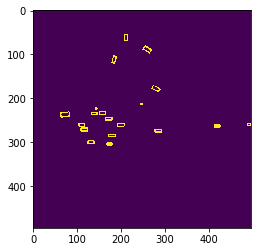

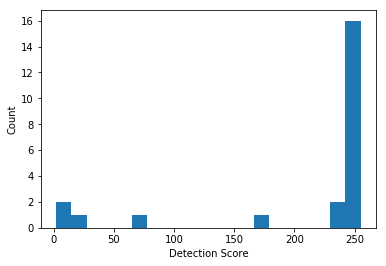

In [52]:
print("Total amount of boxes:", np.sum([len(x) for x in detection_boxes]))
    

# Visualize the boxes in the first sample
t = np.zeros_like(predictions_opened[0])
for sample_boxes in detection_boxes[0]:
    box_pix = np.int0(sample_boxes)
    cv2.drawContours(t,[box_pix],0,(255),2)
plt.imshow(t)
plt.show()

# Visualize their probabilities
plt.hist(detection_scores[0], bins=20)
plt.xlabel("Detection Score")
plt.ylabel("Count")
plt.show()

# Transform predicted boxes back into world space

In [53]:
def create_transformation_matrix_to_voxel_space(shape, voxel_size, offset):
    """
    Constructs a transformation matrix given an output voxel shape such that (0,0,0) ends up in the center.
    Voxel_size defines how large every voxel is in world coordinate, (1,1,1) would be the same as Minecraft voxels.
    
    An offset per axis in world coordinates (metric) can be provided, this is useful for Z (up-down) in lidar points.
    """
    
    shape, voxel_size, offset = np.array(shape), np.array(voxel_size), np.array(offset)
    
    tm = np.eye(4, dtype=np.float32)
    translation = shape/2 + offset/voxel_size
    
    tm = tm * np.array(np.hstack((1/voxel_size, [1])))
    tm[:3, 3] = np.transpose(translation)
    return tm

def transform_points(points, transf_matrix):
    """
    Transform (3,N) or (4,N) points using transformation matrix.
    """
    if points.shape[0] not in [3,4]:
        raise Exception("Points input should be (3,N) or (4,N) shape, received {}".format(points.shape))
    return transf_matrix.dot(np.vstack((points[:3, :], np.ones(points.shape[1]))))[:3, :]


def car_to_voxel_coords(points, shape, voxel_size, z_offset=0):
    if len(shape) != 3:
        raise Exception("Voxel volume shape should be 3 dimensions (x,y,z)")
        
    if len(points.shape) != 2 or points.shape[0] not in [3, 4]:
        raise Exception("Input points should be (3,N) or (4,N) in shape, found {}".format(points.shape))

    tm = create_transformation_matrix_to_voxel_space(shape, voxel_size, (0, 0, z_offset))
    p = transform_points(points, tm)
    return p

def create_voxel_pointcloud(points, shape, voxel_size=(0.5,0.5,1), z_offset=0):

    points_voxel_coords = car_to_voxel_coords(points.copy(), shape, voxel_size, z_offset)
    points_voxel_coords = points_voxel_coords[:3].transpose(1,0)
    points_voxel_coords = np.int0(points_voxel_coords)
    
    bev = np.zeros(shape, dtype=np.float32)
    bev_shape = np.array(shape)

    within_bounds = (np.all(points_voxel_coords >= 0, axis=1) * np.all(points_voxel_coords < bev_shape, axis=1))
    
    points_voxel_coords = points_voxel_coords[within_bounds]
    coord, count = np.unique(points_voxel_coords, axis=0, return_counts=True)
        
    # Note X and Y are flipped:
    bev[coord[:,1], coord[:,0], coord[:,2]] = count
    
    return bev

def normalize_voxel_intensities(bev, max_intensity=16):
    return (bev/max_intensity).clip(0,1)


In [54]:

# We quantize to uint8 here to conserve memory. We're allocating >20GB of memory otherwise.
# predictions = np.zeros((len(test_loader), 1+len(classes), 336, 336), dtype=np.uint8)from lyft_dataset_sdk.eval.detection.mAP_evaluation import Box3D, recall_precision
pred_box3ds = []

# This could use some refactoring..
for (sample_token, sample_boxes, sample_detection_scores, sample_detection_class) in tqdm_notebook(zip(sample_tokens, detection_boxes, detection_scores, detection_classes), total=len(sample_tokens)):
    sample_boxes = sample_boxes.reshape(-1, 2) # (N, 4, 2) -> (N*4, 2)
    sample_boxes = sample_boxes.transpose(1,0) # (N*4, 2) -> (2, N*4)

    # Add Z dimension
    sample_boxes = np.vstack((sample_boxes, np.zeros(sample_boxes.shape[1]),)) # (2, N*4) -> (3, N*4)

    sample = level5data.get("sample", sample_token)
    sample_lidar_token = sample["data"]["LIDAR_TOP"]
    lidar_data = level5data.get("sample_data", sample_lidar_token)
    lidar_filepath = level5data.get_sample_data_path(sample_lidar_token)
    ego_pose = level5data.get("ego_pose", lidar_data["ego_pose_token"])
    ego_translation = np.array(ego_pose['translation'])

    global_from_car = transform_matrix(ego_pose['translation'],
                                       Quaternion(ego_pose['rotation']), inverse=False)

    car_from_voxel = np.linalg.inv(create_transformation_matrix_to_voxel_space(bev_shape, voxel_size, (0, 0, z_offset)))


    global_from_voxel = np.dot(global_from_car, car_from_voxel)
    sample_boxes = transform_points(sample_boxes, global_from_voxel)

    # We don't know at where the boxes are in the scene on the z-axis (up-down), let's assume all of them are at
    # the same height as the ego vehicle.
    sample_boxes[2,:] = ego_pose["translation"][2]


    # (3, N*4) -> (N, 4, 3)
    sample_boxes = sample_boxes.transpose(1,0).reshape(-1, 4, 3)

#     box_height = 1.75
    box_height = np.array([class_heights[cls] for cls in sample_detection_class])

    # Note: Each of these boxes describes the ground corners of a 3D box.
    # To get the center of the box in 3D, we'll have to add half the height to it.
    sample_boxes_centers = sample_boxes.mean(axis=1)
    sample_boxes_centers[:,2] += box_height/2

    # Width and height is arbitrary - we don't know what way the vehicles are pointing from our prediction segmentation
    # It doesn't matter for evaluation, so no need to worry about that here.
    # Note: We scaled our targets to be 0.8 the actual size, we need to adjust for that
    sample_lengths = np.linalg.norm(sample_boxes[:,0,:] - sample_boxes[:,1,:], axis=1) * 1/box_scale
    sample_widths = np.linalg.norm(sample_boxes[:,1,:] - sample_boxes[:,2,:], axis=1) * 1/box_scale
    
    sample_boxes_dimensions = np.zeros_like(sample_boxes_centers) 
    sample_boxes_dimensions[:,0] = sample_widths
    sample_boxes_dimensions[:,1] = sample_lengths
    sample_boxes_dimensions[:,2] = box_height

    for i in range(len(sample_boxes)):
        translation = sample_boxes_centers[i]
        size = sample_boxes_dimensions[i]
        class_name = sample_detection_class[i]
        ego_distance = float(np.linalg.norm(ego_translation - translation))
    
        
        # Determine the rotation of the box
        v = (sample_boxes[i,0] - sample_boxes[i,1])
        v /= np.linalg.norm(v)
        r = R.from_dcm([
            [v[0], -v[1], 0],
            [v[1],  v[0], 0],
            [   0,     0, 1],
        ])
        quat = r.as_quat()
        # XYZW -> WXYZ order of elements
        quat = quat[[3,0,1,2]]
        
        detection_score = float(sample_detection_scores[i])

        
        box3d = Box3D(
            sample_token=sample_token,
            translation=list(translation),
            size=list(size),
            rotation=list(quat),
            name=class_name,
            score=detection_score
        )
        pred_box3ds.append(box3d)


In [55]:
pred_box3ds[0]

{'sample_token': '059c59225b3980ffd9075f7a1aec6d1ba85e5e6bc1cebd4c165049cc787e5db6', 'translation': [1638.9225314394625, 1339.429067898155, -20.23742285899791], 'size': [3.666662441770225, 1.665307504003969, 1.72], 'rotation': [0.8686420978361692, 0.0, 0.0, 0.49544011330006266], 'name': 'car', 'volume': 10.502527223758692, 'score': 236.0}

# Creating Submission File

In [56]:
sub = {}
for i in tqdm_notebook(range(len(pred_box3ds))):
#     yaw = -np.arctan2(pred_box3ds[i].rotation[2], pred_box3ds[i].rotation[0])
    yaw = 2*np.arccos(pred_box3ds[i].rotation[0])
    pred =  str(pred_box3ds[i].score/255) + ' ' + str(pred_box3ds[i].center_x)  + ' '  + \
    str(pred_box3ds[i].center_y) + ' '  + str(pred_box3ds[i].center_z) + ' '  + \
    str(pred_box3ds[i].width) + ' ' \
    + str(pred_box3ds[i].length) + ' '  + str(pred_box3ds[i].height) + ' ' + str(yaw) + ' ' \
    + str(pred_box3ds[i].name) + ' ' 
        
    if pred_box3ds[i].sample_token in sub.keys():     
        sub[pred_box3ds[i].sample_token] += pred
    else:
        sub[pred_box3ds[i].sample_token] = pred        
    
sample_sub = pd.read_csv('/home/bob/data/lyft_data/sample_submission.csv')
for token in set(sample_sub.Id.values).difference(sub.keys()):
    print(token)
    sub[token] = ''

In [57]:
sub = pd.DataFrame(list(sub.items()))
sub.columns = sample_sub.columns
sub.head()

,Id,PredictionString
0,059c59225b3980ffd9075f7a1aec6d1ba85e5e6bc1cebd...,0.9254901960784314 1638.9225314394625 1339.429...
1,73cf5682c1d51bdc344bd31693c7217f671e8e2fea8d22...,0.9372549019607843 1118.0891933995185 1709.679...
2,cbb7ceca83cdfdf027e179a5fa87035b03d4c5371722fc...,1.0 1266.5211655501637 1520.0637585793456 -23....
3,299ee754df0a89992893c920f03c42a7cb579664f96d59...,0.8470588235294118 2732.2111488776945 710.4663...
4,934665bca25f3caaf720a2e8db12c6891cc2f327bdea4f...,0.8823529411764706 1011.5637353911071 1930.159...


In [58]:
sub.tail()

,Id,PredictionString
27463,d8fc81afd0c37ffde32aad62d938771d0af6255bb6f04d...,0.8588235294117647 2081.457551966028 1081.6936...
27464,7634d1d7eda6a559eb165712292670d56e112b4399a84b...,0.9372549019607843 1676.948276953967 1246.9614...
27465,e6d255b6b69b490bb2878164c0fc226dc95b6992516c98...,0.9686274509803922 1127.0758977946316 1632.992...
27466,b6c7c0f4d212193093230c72068fc1304ac0df04576ea4...,0.8980392156862745 2578.3845759284845 717.3280...
27467,e907c70788f1ddb22035f8abebd08e7198974ad819cb09...,0.996078431372549 455.84122930739545 2951.4186...


In [59]:
sub.to_csv('unet496_epoch13_pred.csv',index=False)

In [60]:
sub.shape

(27468, 2)